In [2]:
"""
Baseline Heuristics
"""
# Import pickle
import pickle

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

import pylab as py

import scipy.stats as stats

from IPython.display import clear_output

import sys

import os

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')

from utils.utils_stats import mean_confidence_interval


"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
simulated_instances = True
print("Simulated instances ", simulated_instances)

if simulated_instances:
    #path_baseline_heuristics = "results/simulated/MFDS_vs_RL/results_test/results_baseline_heuristics.pickle"
    path_baseline_heuristics = "results/temp/most_recent/results_baseline_heuristics_smallworld.pickle"
else:
    #path_baseline_heuristics = "results/real/MFDS_vs_RL/results_versailles_baseline_heuristics.pickle"
    #path_baseline_heuristics = "results/results_lieusaint2_heuristics.pickle"
    path_baseline_heuristics = "results/real/MFDS_vs_RL/versailles/gpickle/random_pairs/results_baseline_heuristics_versailles.pickle"


with open(path_baseline_heuristics, 
          'rb') as handle:
    file = pickle.load(handle)
    test_names = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data_res_heur = file["data"]

"""
dict_results[(ind_instance, test)] = (flow_val_res, flow_res, m_flow_res, 
                                        prop_fsupp, prop_sp, trans_func_res)
test   -->    ["min_time", 
              "max_capacity", 
              "trans_func", 
              "random"]
"""
# Unzip to display (each metric on one list)
nb_instances = len({id_inst for id_inst, _ in data_res_heur.keys()})
dict_perfs_heurs = {test_names[i]:[] for i in range(len(test_names))}
for test_name in test_names:
    metrics_instances = dict_perfs_heurs[test_name]
    for j in range(len(metric_names)):
        metrics_instances.append([(id_inst, 
                                   data_res_heur[(id_inst, test_name)][j]) 
                                        for id_inst in range(nb_instances)])
        metrics_instances[-1].sort(key = lambda x : -x[1])

# Display
if simulated_instances:
    save_path = "results/simulated/MFDS_vs_RL/"
else:
    #save_path = "results/real/MFDS_vs_RL/baseline_heuristics/"
    #save_path = "results/real/MFDS_vs_RL/lieu_saint2/baseline_heuristics/"
    save_path = "results/real/MFDS_vs_RL/versailles/random/baseline_heuristics/"

#save_path = False
colors = ['b', 'g', 'k', 'm', 'r', 'y']
markers = ["o", "^", "s", "x", "*", "h", "p"]
show_std = False
bins = 'auto'
#bins = 100
#force = None
force = "bootstrap"
with_pval_norm = False
for i in range(len(metric_names)):
    fig, fig3 = plt.figure(), plt.figure()
    fig2, ax = plt.subplots(len(test_names), figsize=(8, 12))
    for j in range(len(test_names)):
        test_name = test_names[j]
        ### !!!!! size of vals !!!!! bedelha 
        vals = [e[1] for e in dict_perfs_heurs[test_name][i]]
        mean_ = np.mean(vals)
        std_ = np.std(vals, ddof=1)
        ci, pval_norm = mean_confidence_interval(vals, 
                                                 confidence_normality_test = 0.95,
                                                 force = force,
                                                 confidence_level = 0.95)
        conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
        added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
        if show_std:
            label = test_name+" "+str(round(mean_,3))+"+/-"+str(round(std_,3))+" "+conf_int_str+added_pval_norm
        else:
            label = test_name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
        
        py.figure(fig.number)
        plt.scatter(list(range(len(vals))), 
                    vals, 
                    color = colors[j],
                    marker = markers[j], 
                    alpha = 0.5, 
                    label = label)
        
        py.figure(fig2.number)
        sns.histplot(vals,   
                    color = colors[j], 
                    edgecolor = 'black', 
                    alpha = 0.5,
                    label = label,
                    bins = bins,
                    kde = True,
                    ax = ax[j])
        #sns.kdeplot(data = vals, ax = ax[j])
        
        py.figure(fig3.number)
        box = plt.boxplot(vals, 
                          patch_artist = True,
                          widths = 0.6,
                          positions = [j+1])
        box['boxes'][0].set_facecolor(colors[j])
        box['medians'][0].set_color("white")

        if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
            vals_centred = np.array([(v - mean_)/std_ for v in vals])
            # Create a qq_plot
            fig4 = sm.qqplot(vals_centred, line ='45')
            # Save the qqplot
            path = os.path.join(save_path,
                                "qq_plots",
                                "com_base_heurs_"+metric_names[i]+"_"+label+".png")
            py.figure(fig4.number)
            py.savefig(path)
            plt.close(fig4)
    
    py.figure(fig.number)
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path:
        fig.savefig(os.path.join(save_path, 
                                "comp_gen_base_heurs_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    plt.close(fig)

    py.figure(fig2.number)
    for k in range(len(test_names)):
        #ax[k].set_xlabel(metric_names[i])
        #ax[k].set_xlabel("Frequency")
        ax[k].legend(loc="upper right")
        ax[k].grid(visible = True)
    fig2.tight_layout()
    if save_path:
        fig2.savefig(os.path.join(save_path, 
                                  "hist_comp_gen_base_heurs_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    plt.close(fig2)


    py.figure(fig3.number)
    plt.xlabel("methods")
    plt.ylabel("ranges")
    #plt.legend(loc="upper right")
    plt.xticks([j+1 for j in range(len(test_names))], test_names)
    if save_path:
        fig3.savefig(os.path.join(save_path, 
                                  "box_comp_gen_base_heurs_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    plt.close(fig3)

plt.show()

clear_output(wait=False)

C:\Users\HADDAM\AppData\Local\Temp\ipykernel_20344\3000249301.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2, ax = plt.subplots(3, figsize=(8, 12))


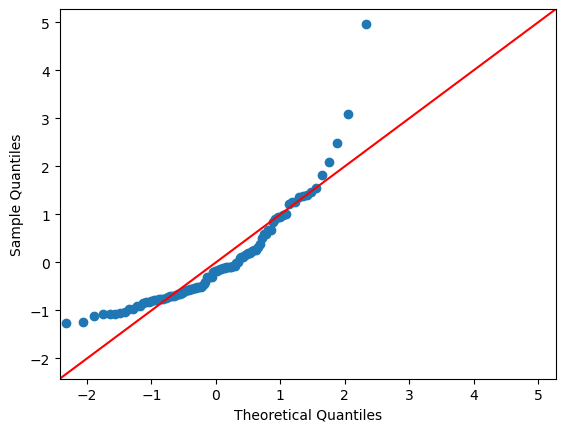

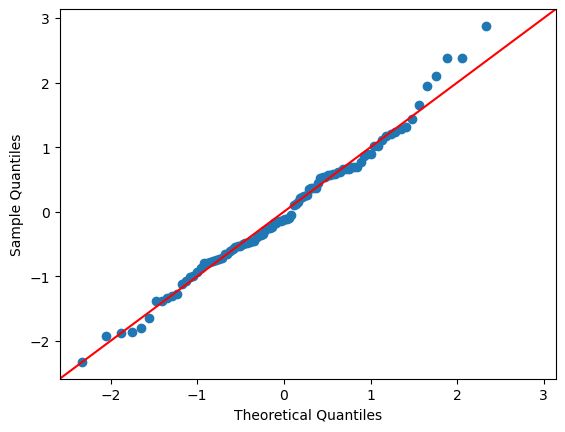

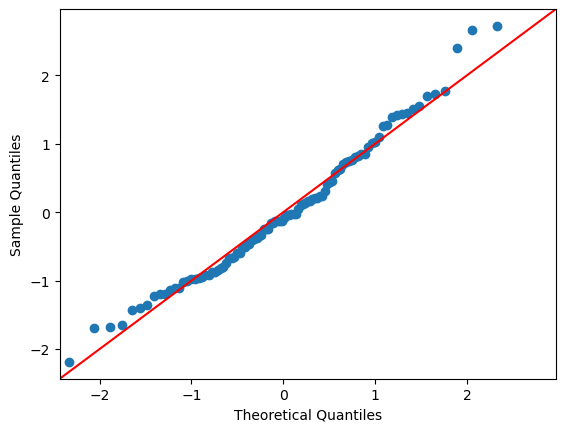

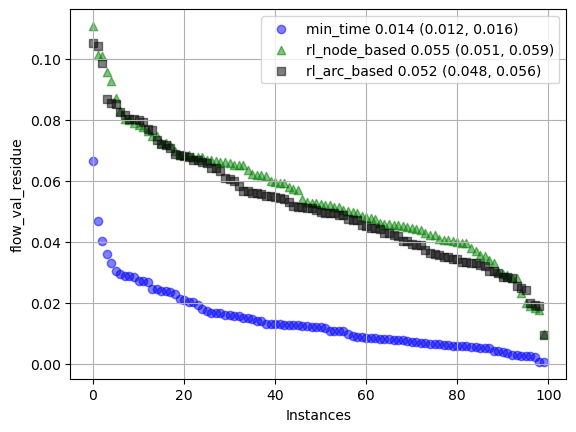

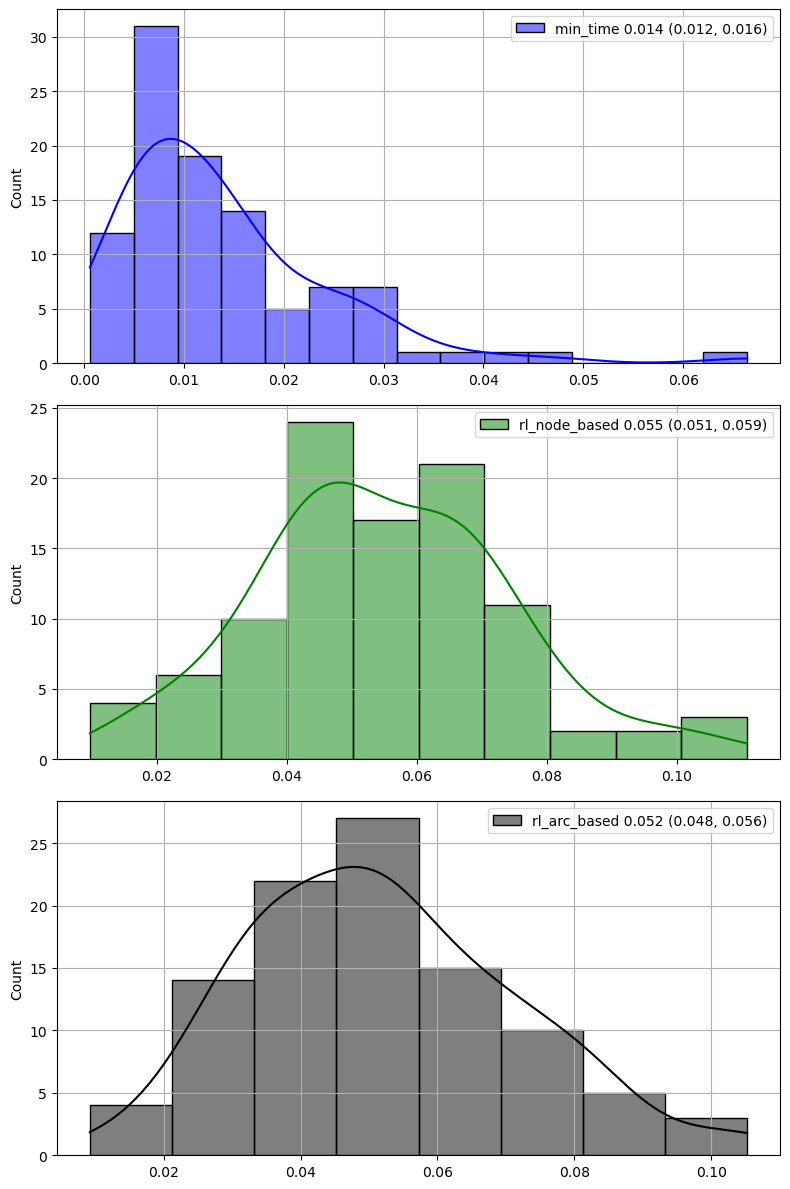

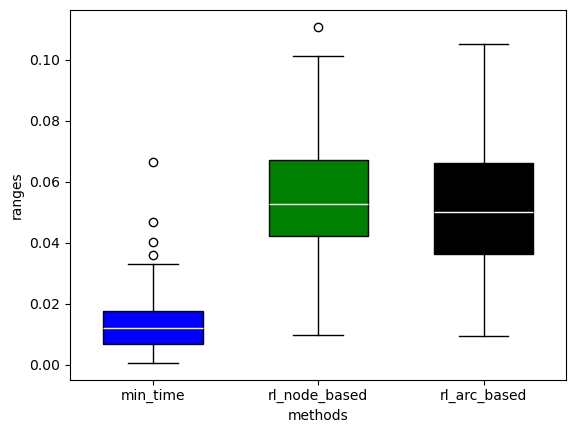

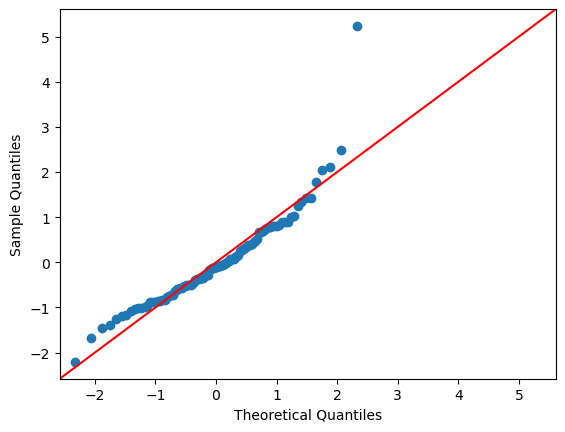

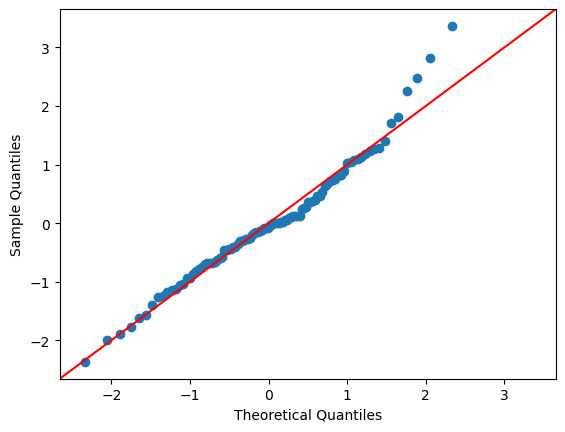

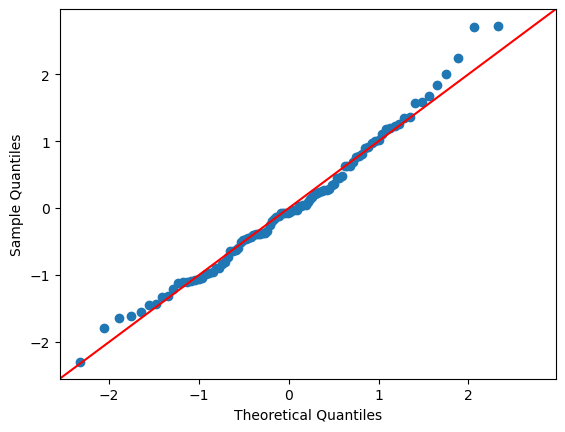

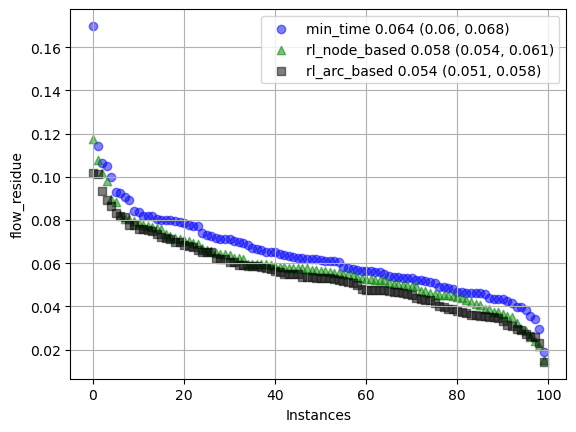

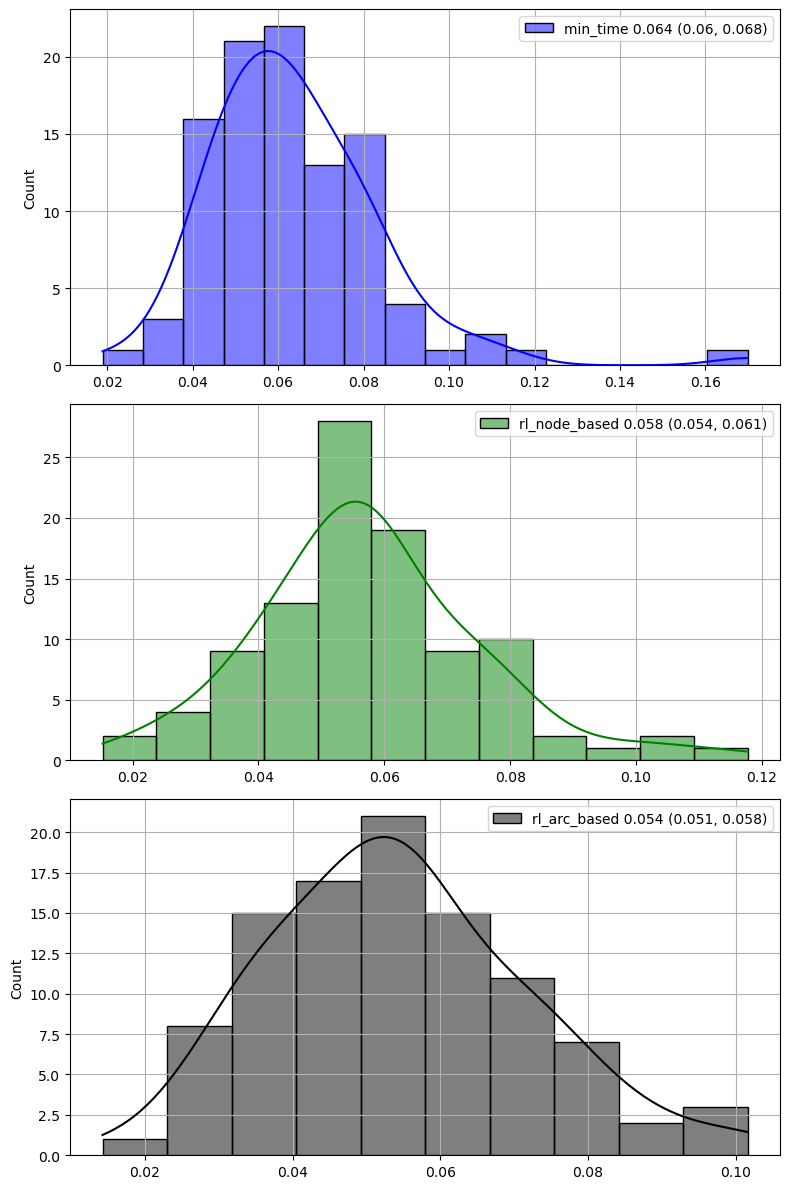

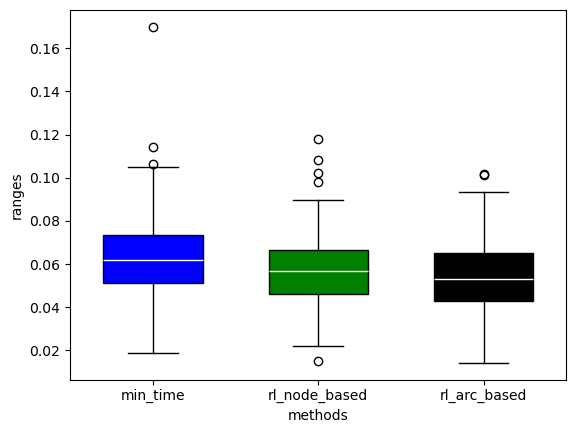

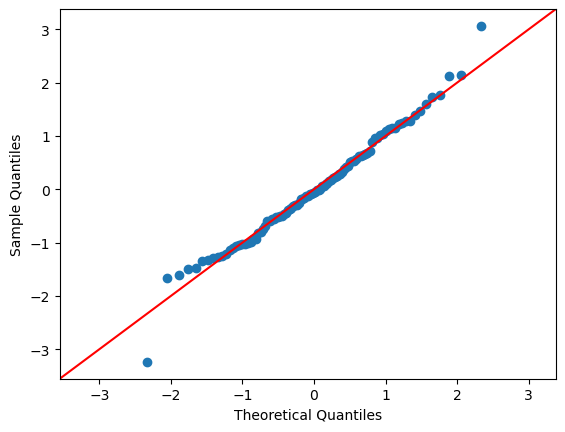

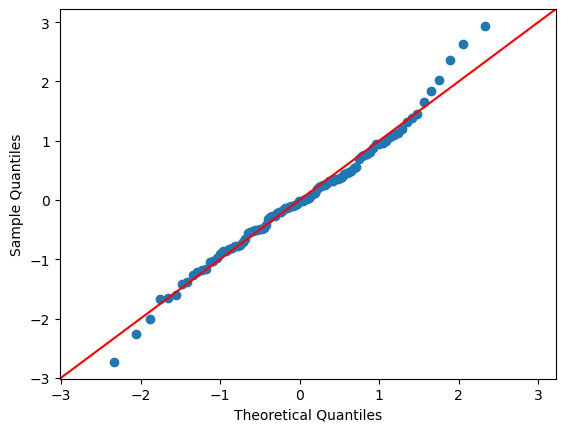

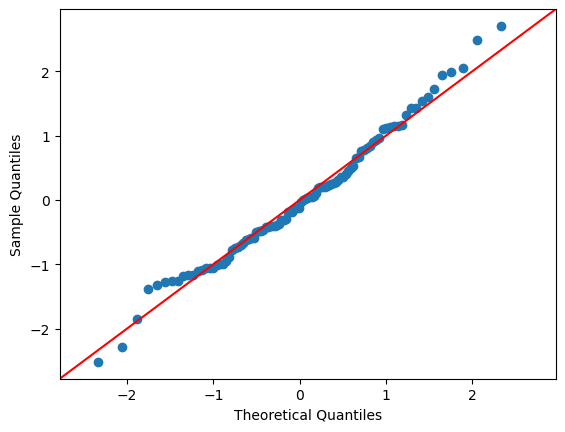

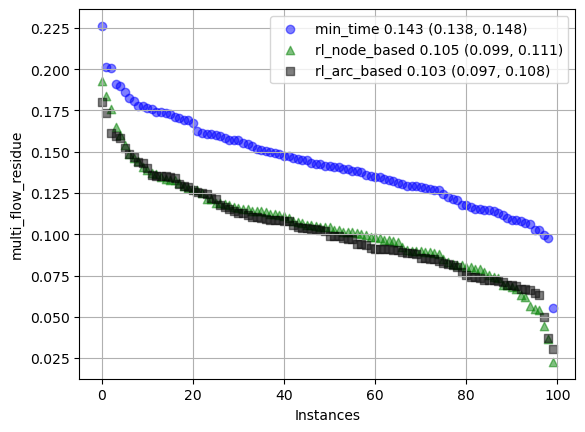

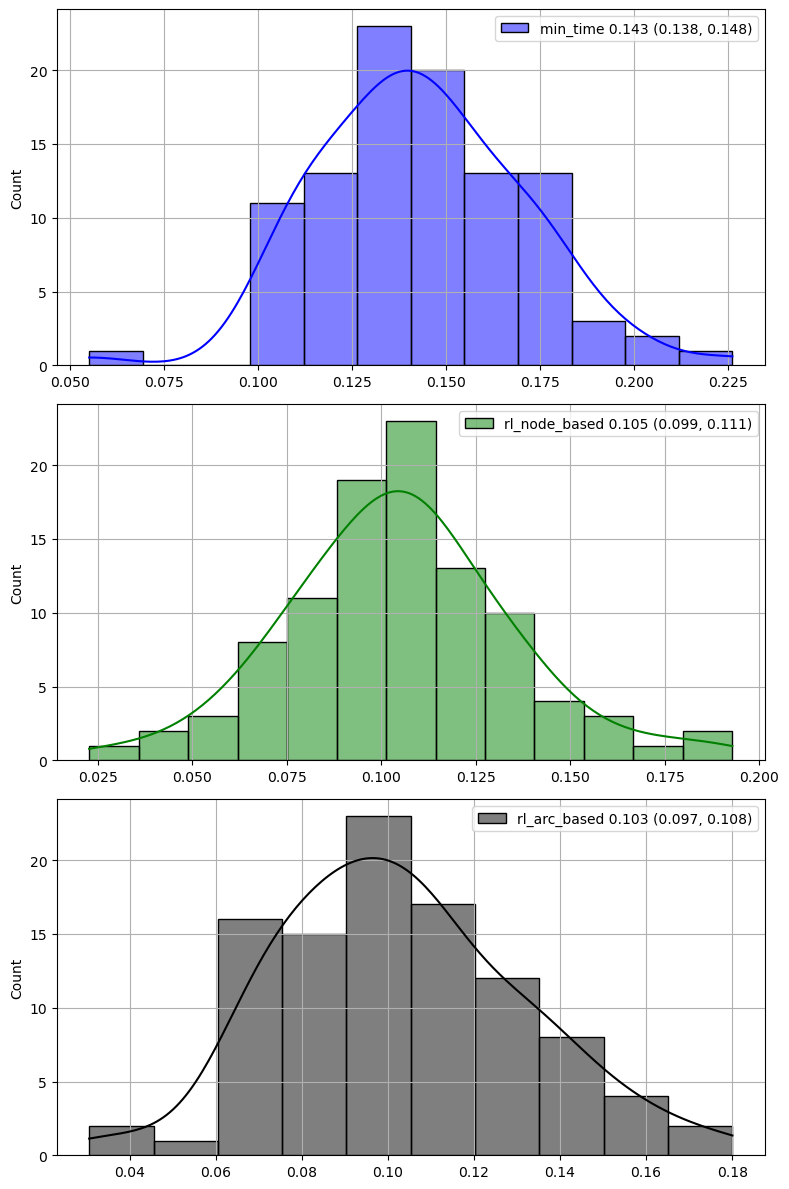

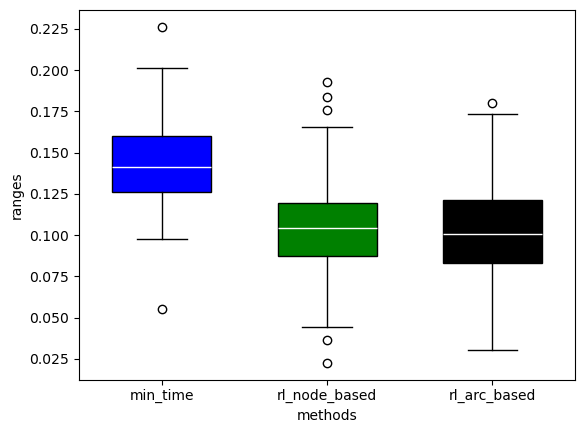

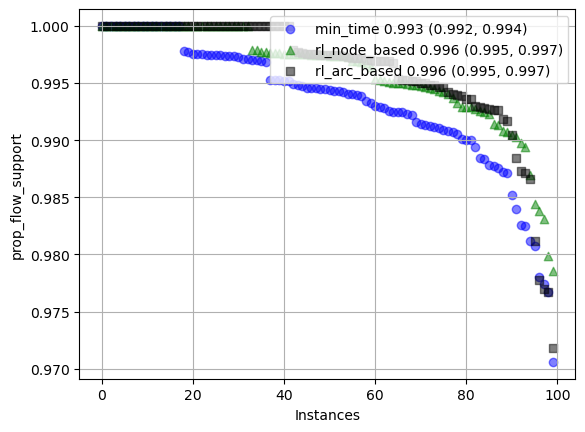

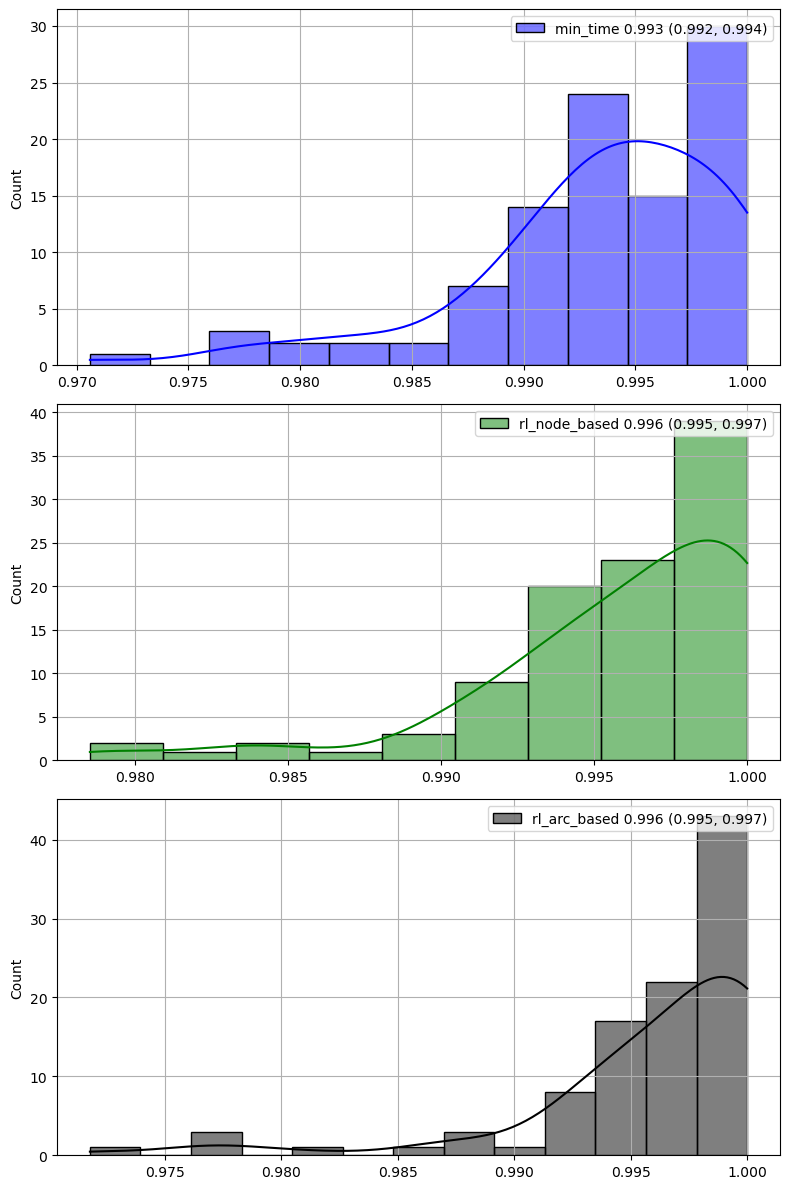

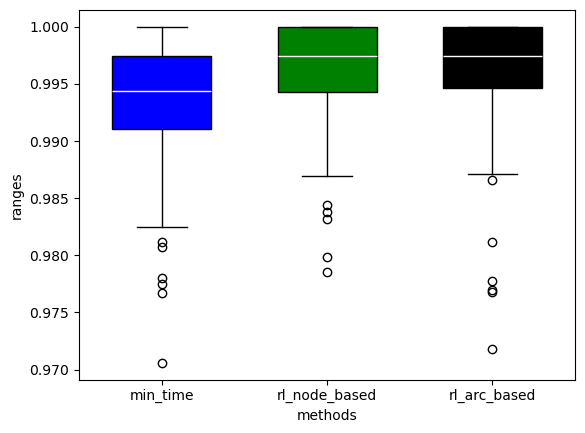

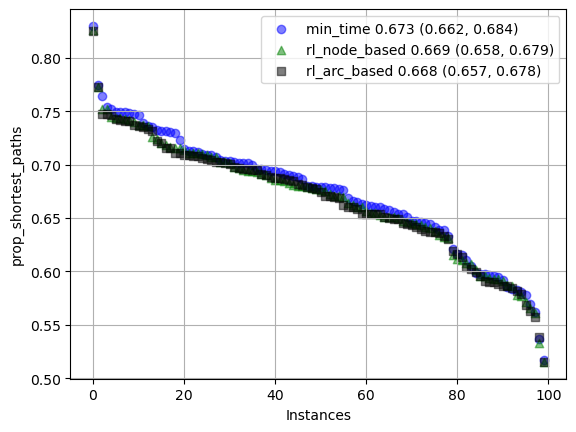

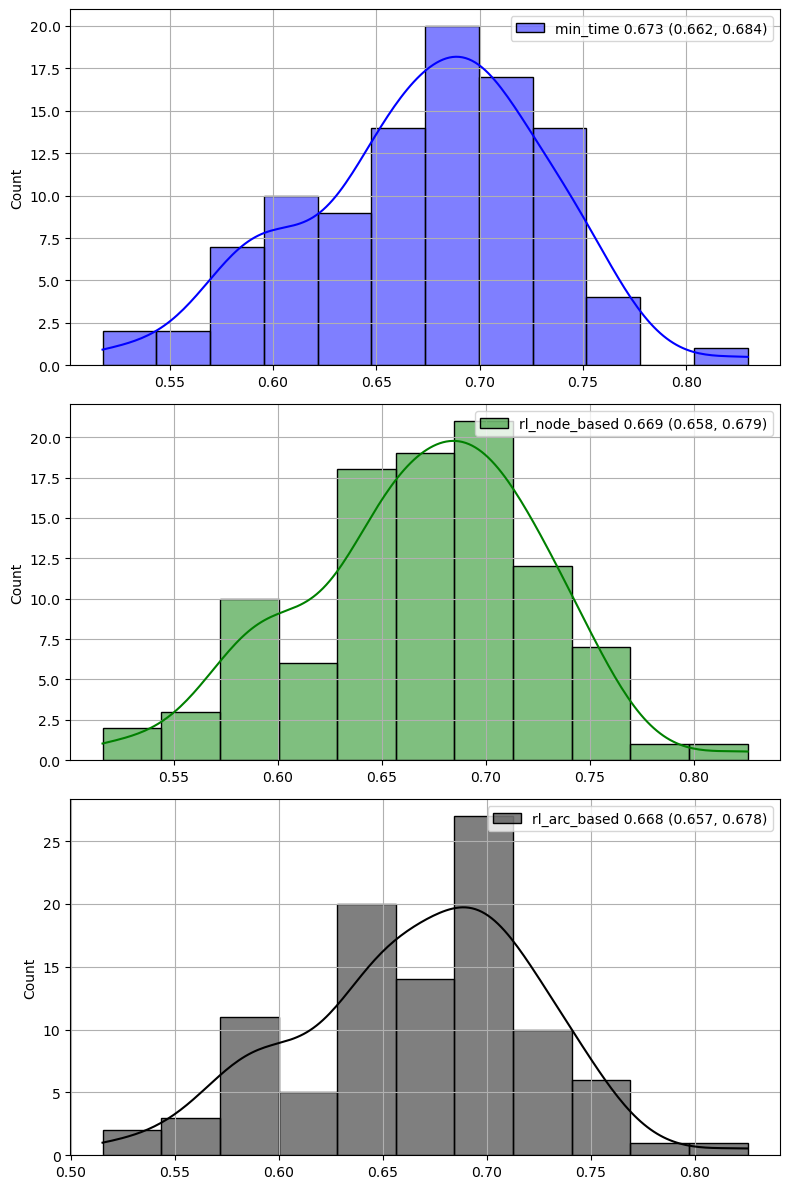

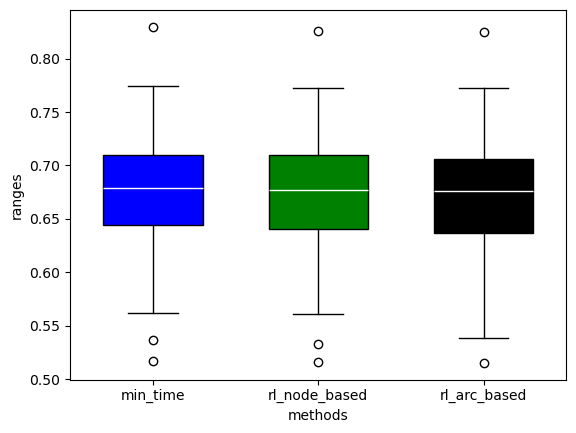

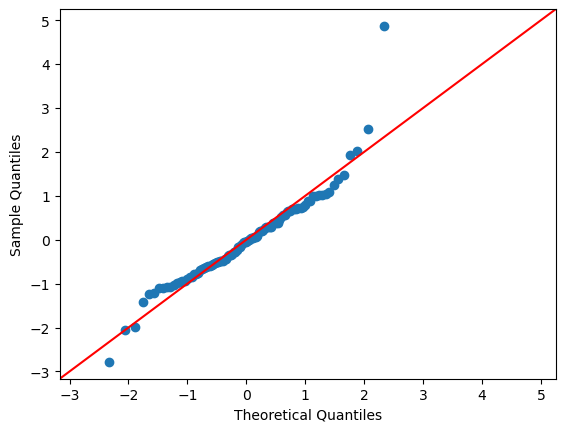

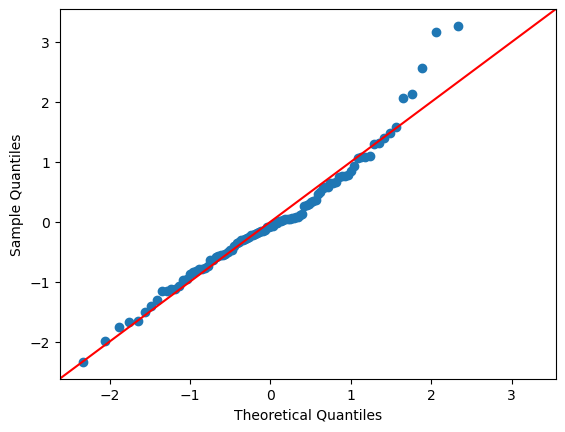

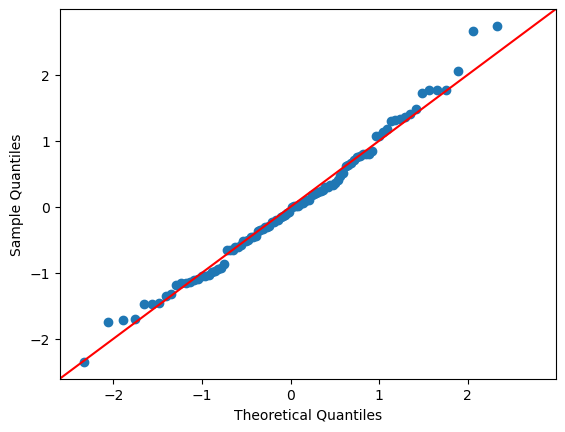

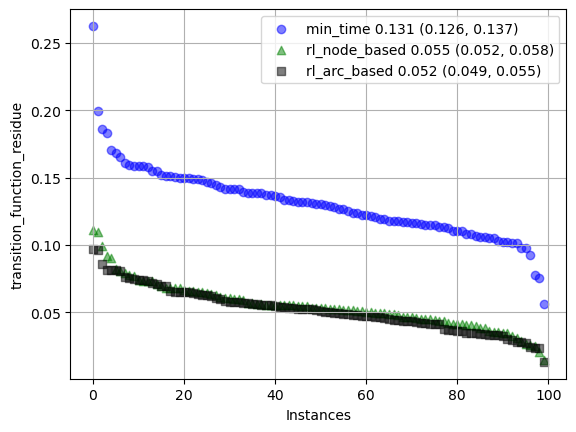

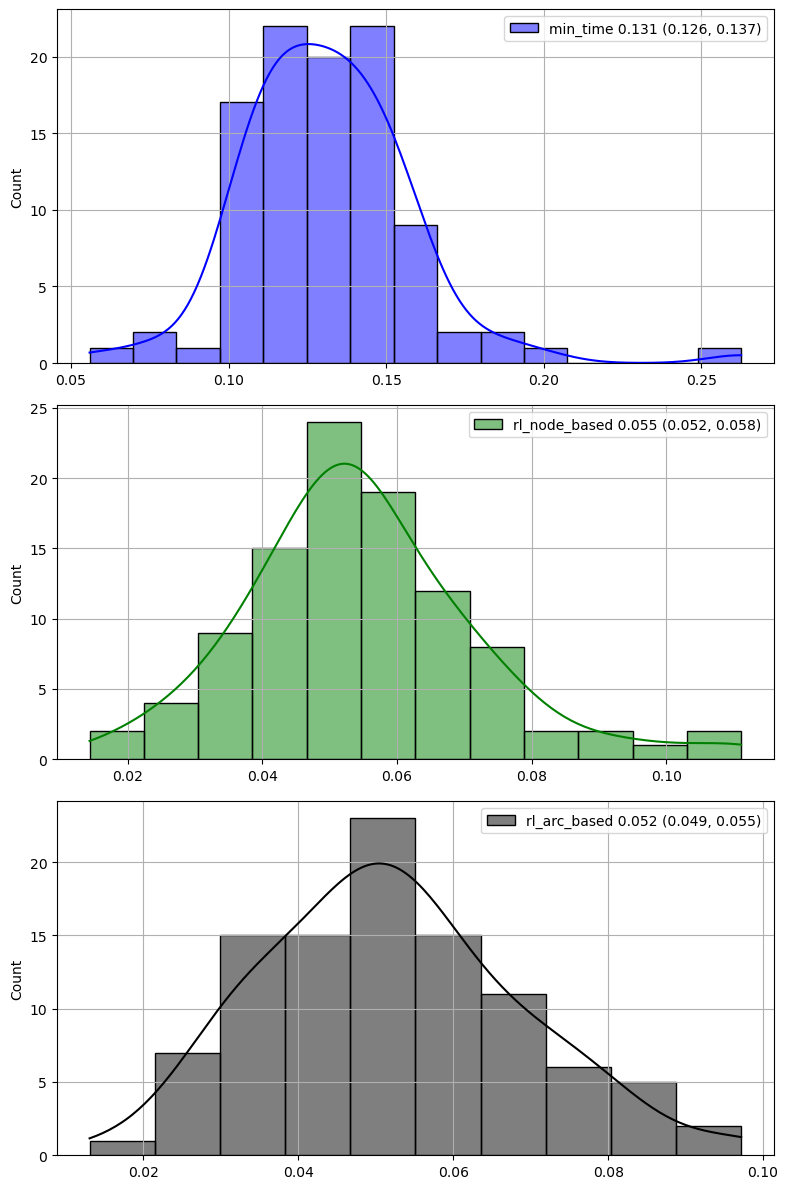

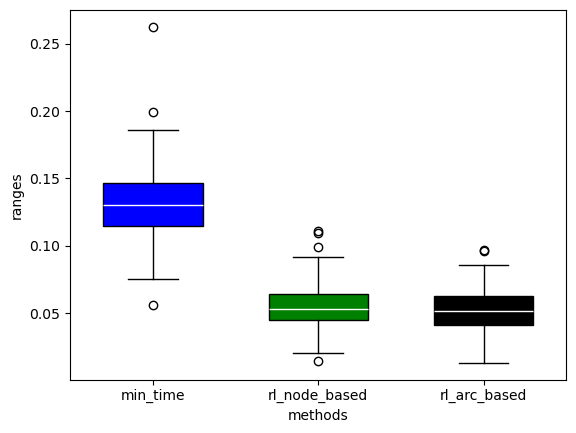

-----------------------------------------------------------------------------
Result of hypothesis testing vals_mf_node_based - vals_mf_arc_based for flow_val_residue
H0:ge  {'decision': 'not reject', 'pvalue': 0.85168}
H0:eq  {'decision': 'not reject', 'pvalue': 0.29353}
H0:le  {'decision': 'not reject', 'pvalue': 0.14767}
-----------------------------------------------------------------------------
Result of hypothesis testing vals_mf_node_based - vals_mf_arc_based for flow_residue
H0:ge  {'decision': 'not reject', 'pvalue': 0.90854}
H0:eq  {'decision': 'not reject', 'pvalue': 0.18613}
H0:le  {'decision': 'not reject', 'pvalue': 0.09305}
-----------------------------------------------------------------------------
Result of hypothesis testing vals_mf_node_based - vals_mf_arc_based for multi_flow_residue
H0:ge  {'decision': 'not reject', 'pvalue': 0.6886}
H0:eq  {'decision': 'not reject', 'pvalue': 0.61766}
H0:le  {'decision': 'not reject', 'pvalue': 0.30906}
-------------------------

In [3]:
"""
Simulated : RL Heuristics vs baseline heuristics
"""

# Import pickle
import pickle

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

import pylab as py

import scipy.stats as stats


from IPython.display import clear_output

import os

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')

from utils.utils_stats import mean_confidence_interval, test_twoind_sample



##########################  Baseline heuristics handling  ########################## 
"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""

#path_baseline_heuristics = "results/simulated/MFDS_vs_RL/results_test/results_baseline_heuristics.pickle"
path_baseline_heuristics = "results/temp/most_recent/results_baseline_heuristics_smallworld.pickle"
with open(path_baseline_heuristics, 
          'rb') as handle:
    file = pickle.load(handle)
    test_names = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data_res_heur = file["data"]

nb_instances = len({id_inst for id_inst, _ in data_res_heur.keys()})

"""
dict_results[(ind_instance, test)] = (flow_val_res, flow_res, m_flow_res, 
                                        prop_fsupp, prop_sp, trans_func_res)
test   -->    ["min_time", 
              "max_capacity", 
              "trans_func", 
              "random"]
"""
# Unzip to display (each metric on one list)
#algo_type = "trans_func"
algo_type = "min_time"
metrics_instances_heurs = []
for j in range(len(metric_names)):
    metrics_instances_heurs.append([(id_inst, 
                                     data_res_heur[(id_inst, algo_type)][j]) 
                                        for id_inst in range(nb_instances)])
    metrics_instances_heurs[-1].sort(key = lambda x : -x[1])



##########################  RL heuristics handling  ##########################
"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""

#path_rl_heuristics = "results/simulated/MFDS_vs_RL/results_test/results_rl_heuristics.pickle"
path_rl_heuristics = "results/temp/most_recent/results_rl_heuristics_discount_by_length_smallworld.pickle"
with open(path_rl_heuristics, 
          'rb') as handle:
    file = pickle.load(handle)
    test_infos = file["res_key_metadata"]
    #metric_names = file["res_value_metadata"]
    data = file["data"]

"""
dict_results[(ind_instance, test_infos)] = (flow_val_res, flow_res, 
                                            m_flow_res, prop_fsupp, 
                                            prop_sp, trans_func_res,
                                            reward)
test_infos = (path_type_selector, path_card_criteria, lr_rate, (coeff1, coeff2, coeff3))
"""

# The set of all the learning rates
lr_rates = set(lr_rate for _, (_, _, lr_rate, _) in data)
# The data associated to the node based case
data_node_based = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                for (ind_instance, test_infos) in data
                                                    if test_infos[0] == "rl_node_based" and\
                                                        test_infos[1] == "one_for_each" and\
                                                            test_infos[3][-1] != 0}
# The data associated to the arc based case
data_arc_based = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                for (ind_instance, test_infos) in data
                                                    if test_infos[0] == "rl_arc_based" and\
                                                        test_infos[1] == "one_for_each" and\
                                                            test_infos[3][-1] != 0}

# Calculate the best learning rate for the node_based case
mean_rew_by_lr_rate = {np.mean([data_node_based[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_node_based
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_node_based = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]

# Calculate the best learning rate for the node_based case
mean_rew_by_lr_rate = {np.mean([data_arc_based[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_arc_based
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_arc_based = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]


# Filter to leave only the best value of the learning parameter for the node based case
data_res_rl_node_based = {(ind_instance, 
                            (test_infos[0], 
                            test_infos[1], 
                            test_infos[3])):data_node_based[(ind_instance, test_infos)]+(lr_rate_max_node_based,)
                                                for (ind_instance, test_infos) in data_node_based
                                                    if test_infos[2] == lr_rate_max_node_based}


# Filter to leave only the best value of the learning parameter for the arc based case
data_res_rl_arc_based = {(ind_instance, 
                            (test_infos[0], 
                            test_infos[1], 
                            test_infos[3])):data_arc_based[(ind_instance, test_infos)]+(lr_rate_max_arc_based,)
                                                for (ind_instance, test_infos) in data_arc_based
                                                    if test_infos[2] == lr_rate_max_arc_based}

# Unzip to display (each metric on one list)
metrics_instances_rl_node_based = []
test_info = ("rl_node_based", "one_for_each", (0.33, 0.33, 0.34))
for j in range(len(metric_names)):
    metrics_instances_rl_node_based.append([(id_inst, 
                                            data_res_rl_node_based[(id_inst, test_info)][j])
                                                for id_inst in range(nb_instances)])
    metrics_instances_rl_node_based[-1].sort(key = lambda x : -x[1])

metrics_instances_rl_arc_based = []
test_info = ("rl_arc_based", "one_for_each", (0.33, 0.33, 0.34))
for j in range(len(metric_names)):
    metrics_instances_rl_arc_based.append([(id_inst, 
                                            data_res_rl_arc_based[(id_inst, test_info)][j])
                                                for id_inst in range(nb_instances)])
    metrics_instances_rl_arc_based[-1].sort(key = lambda x : -x[1])

# Diplay the curves
#save_path = "results/simulated/MFDS_vs_RL/results_test/rl_vs_baseline"
save_path = "results/simulated/MFDS_vs_RL/nodes_200_pairs=20_capacity=50_smallworldlike/rl_vs_baseline"
colors = ['b', 'g', 'k', 'r', 'y', 'brown', 'purple', 'orange',  'gray', 'pink']
markers = ["o", "^", "s", "x", "*", "h", "p", "+"]
bins = 'auto'
#bins = 100
#force = None
force = "bootstrap"
with_pval_norm = False
close = False
for i in range(len(metric_names)):
    fig, fig3 = plt.figure(), plt.figure()
    fig2, ax = plt.subplots(3, figsize=(8, 12))
    
    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_heurs[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = algo_type
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[0],
                marker = markers[0], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[0], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[0])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [1])
    box['boxes'][0].set_facecolor(colors[0])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        py.figure(fig4.number)
        # Save the qqplot
        if save_path is not None:
            path = os.path.join(save_path,
                                "qq_plots",
                                "comp_rl_vs_baseline_"+metric_names[i]+"_"+label+".png")
            py.savefig(path)
        if close: plt.close(fig4)
    

    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_rl_node_based[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "rl_node_based"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[1],
                marker = markers[1], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[1], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[1])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [2])
    box['boxes'][0].set_facecolor(colors[1])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        py.figure(fig4.number)
        if save_path is not None:
            path = os.path.join(save_path,
                                "qq_plots",
                                "comp_rl_vs_baseline_"+metric_names[i]+"_"+label+".png")
            
            py.savefig(path)
        if close: plt.close(fig4)
    
    
    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_rl_arc_based[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "rl_arc_based"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[2],
                marker = markers[2], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[2], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[2])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [3])
    box['boxes'][0].set_facecolor(colors[2])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        py.figure(fig4.number)
        if save_path is not None:
            path = os.path.join(save_path,
                                "qq_plots",
                                "comp_rl_vs_baseline_"+metric_names[i]+"_"+label+".png")
            
            py.savefig(path)
        if close: plt.close(fig4)
    
    py.figure(fig.number)
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path is not None:
        fig.savefig(os.path.join(save_path, 
                                "comp_rl_vs_baseline_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    if close: plt.close(fig)

    py.figure(fig2.number)
    for k in range(3):
        #ax[k].set_xlabel(metric_names[i])
        #ax[k].set_xlabel("Frequency")
        ax[k].legend(loc="upper right")
        ax[k].grid(visible = True)
    fig2.tight_layout()
    if save_path is not None:
        fig2.savefig(os.path.join(save_path, 
                                  "hist_comp_rl_vs_baseline_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    if close: plt.close(fig2)


    py.figure(fig3.number)
    plt.xlabel("methods")
    plt.ylabel("ranges")
    #plt.legend(loc="upper right")
    plt.xticks([j+1 for j in range(3)], [algo_type, "rl_node_based", "rl_arc_based"])
    if save_path is not None:
        fig3.savefig(os.path.join(save_path, 
                                  "box_comp_rl_vs_baseline_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    if close: plt.close(fig3)


plt.show()

if close: clear_output(wait=False)


for i in range(len(metric_names)):
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        # Compare multi flow residue with satistics test
        vals_mf_node_based = [e[1] for e in metrics_instances_rl_node_based[i]]


        # Construct list of values of the metric for each instance
        vals_mf_arc_based = [e[1] for e in metrics_instances_rl_arc_based[i]]


        dict_result_ge = test_twoind_sample(vals_mf_node_based, 
                                        vals_mf_arc_based,
                                        confidence_normality_test = 0.95,
                                        confidence_level = 0.95,
                                        force = force,
                                        alternative_hypothesis = "less")


        dict_result_eq = test_twoind_sample(vals_mf_node_based, 
                                        vals_mf_arc_based,
                                        confidence_normality_test = 0.95,
                                        confidence_level = 0.95,
                                        force = force,
                                        alternative_hypothesis = "two-sided")


        dict_result_le = test_twoind_sample(vals_mf_node_based, 
                                        vals_mf_arc_based,
                                        confidence_normality_test = 0.95,
                                        confidence_level = 0.95,
                                        force = force,
                                        alternative_hypothesis = "greater")


        # Equality test
        print("-----------------------------------------------------------------------------")
        print("Result of hypothesis testing vals_mf_node_based - vals_mf_arc_based for "+metric_names[i])
        print("H0:ge ", dict_result_ge)
        print("H0:eq ", dict_result_eq)
        print("H0:le ", dict_result_le)

In [ ]:
"""
RL Heuristics one path vs multiple paths
"""

# Import pickle
import pickle

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

import pylab as py

import scipy.stats as stats


from IPython.display import clear_output

import os

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')

from utils.utils_stats import mean_confidence_interval, test_twoind_sample


"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
with open("results/simulated/MFDS_vs_RL/results_test/results_rl_heuristics.pickle", 
          'rb') as handle:
    file = pickle.load(handle)
    test_infos = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data = file["data"]

"""
dict_results[(ind_instance, test_infos)] = (flow_val_res, flow_res, 
                                            m_flow_res, prop_fsupp, 
                                            prop_sp, trans_func_res,
                                            reward)
test_infos = (path_type_selector, path_card_criteria, lr_rate, (coeff1, coeff2, coeff3))
"""

# The set of all the learning rates
lr_rates = set(lr_rate for _, (_, _, lr_rate, _) in data)
# The number of instances
nb_instances = len({id_inst for id_inst, _ in data.keys()})
# The data associated to the one path case
data_one_only = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                for (ind_instance, test_infos) in data
                                                    if test_infos[0] == "rl_arc_based" and\
                                                        test_infos[1] == "one_only" and\
                                                            test_infos[3][-1] != 0}
# The data associated to the multiple path case
data_one_for_each = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                    for (ind_instance, test_infos) in data
                                                        if test_infos[0] == "rl_arc_based" and\
                                                            test_infos[1] == "one_for_each" and\
                                                                test_infos[3][-1] != 0}

# Calculate the best learning rate for the one path case
mean_rew_by_lr_rate = {np.mean([data_one_only[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_one_only
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_one_only = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]

# Calculate the best learning rate for the multiple path case
mean_rew_by_lr_rate = {np.mean([data_one_for_each[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_one_for_each
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_one_for_each = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]


# Filter to leave only the best value of the learning parameter for the one path case
data_res_rl_one_only = {(ind_instance, 
                        (test_infos[0], 
                        test_infos[1], 
                        test_infos[3])):data_one_only[(ind_instance, test_infos)]+(lr_rate_max_one_only,)
                                        for (ind_instance, test_infos) in data_one_only
                                            if test_infos[2] == lr_rate_max_one_only}


# Filter to leave only the best value of the learning parameter for the multiple path case
data_res_rl_one_for_each = {(ind_instance, 
                            (test_infos[0], 
                            test_infos[1], 
                            test_infos[3])):data_one_for_each[(ind_instance, test_infos)]+(lr_rate_max_one_for_each,)
                                                for (ind_instance, test_infos) in data_one_for_each
                                                    if test_infos[2] == lr_rate_max_one_for_each}

# Unzip to display (each metric on one list)
metrics_instances_rl_one_path = []
test_info = ("rl_arc_based", "one_only", (0.33, 0.33, 0.34))
for j in range(len(metric_names)):
    metrics_instances_rl_one_path.append([(id_inst, 
                                            data_res_rl_one_only[(id_inst, test_info)][j])
                                                for id_inst in range(nb_instances)])
    metrics_instances_rl_one_path[-1].sort(key = lambda x : -x[1])

metrics_instances_rl_one_for_each = []
test_info = ("rl_arc_based", "one_for_each", (0.33, 0.33, 0.34))
for j in range(len(metric_names)):
    metrics_instances_rl_one_for_each.append([(id_inst, 
                                                data_res_rl_one_for_each[(id_inst, test_info)][j])
                                                    for id_inst in range(nb_instances)])
    metrics_instances_rl_one_for_each[-1].sort(key = lambda x : -x[1])


# Diplay the curves
save_path = "results/simulated/MFDS_vs_RL/results_test/one_path_vs_multiple_paths"
colors = ['b', 'g', 'k', 'r', 'y', 'brown', 'purple', 'orange',  'gray', 'pink']
markers = ["o", "^", "s", "x", "*", "h", "p", "+"]
bins = 'auto'
#bins = 100
#force = None
force = "bootstrap"
with_pval_norm = False
for i in range(len(metric_names)):
    fig, fig3 = plt.figure(), plt.figure()
    fig2, ax = plt.subplots(2, figsize=(8, 12))

    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_rl_one_path[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "rl_arc_one_path_based"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[0],
                marker = markers[0], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[0], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[0])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [1])
    box['boxes'][0].set_facecolor(colors[0])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        # Save the qqplot
        path = os.path.join(save_path,
                            "qq_plots",
                            "comp_rl_one_vs_multi_"+metric_names[i]+"_"+label+".png")
        py.figure(fig4.number)
        py.savefig(path)
        plt.close(fig4)
    
    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_rl_one_for_each[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "rl_arc_multi_path_based"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[1],
                marker = markers[1], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[1], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[1])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [2])
    box['boxes'][0].set_facecolor(colors[1])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        # Save the qqplot
        path = os.path.join(save_path,
                            "qq_plots",
                            "comp_rl_one_vs_multi_"+metric_names[i]+"_"+label+".png")
        py.figure(fig4.number)
        py.savefig(path)
        plt.close(fig4)


    py.figure(fig.number)
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path:
        fig.savefig(os.path.join(save_path, 
                                "comp_rl_one_vs_multi_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    plt.close(fig)

    py.figure(fig2.number)
    for k in range(2):
        #ax[k].set_xlabel(metric_names[i])
        #ax[k].set_xlabel("Frequency")
        ax[k].legend(loc="upper right")
        ax[k].grid(visible = True)
    fig2.tight_layout()
    if save_path:
        fig2.savefig(os.path.join(save_path, 
                                  "hist_comp_rl_one_vs_multi_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    plt.close(fig2)


    py.figure(fig3.number)
    plt.xlabel("methods")
    plt.ylabel("ranges")
    #plt.legend(loc="upper right")
    plt.xticks([j+1 for j in range(2)], ["rl_arc_one_path_based", "rl_arc_multi_path_based"])
    if save_path:
        fig3.savefig(os.path.join(save_path, 
                                  "box_comp_rl_one_vs_multi_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    plt.close(fig3)

plt.show()

clear_output(wait=False)


for i in range(len(metric_names)):
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        # Compare multi flow residue with satistics test
        vals_mf_one_path = [e[1] for e in metrics_instances_rl_one_path[i]]

        # Construct list of values of the metric for each instance
        vals_mf_one_for_each = [e[1] for e in metrics_instances_rl_one_for_each[i]]


        dict_result_ge = test_twoind_sample(vals_mf_one_path, 
                                        vals_mf_one_for_each,
                                        confidence_normality_test = 0.95,
                                        confidence_level = 0.95,
                                        force = force,
                                        alternative_hypothesis = "less")

        dict_result_eq = test_twoind_sample(vals_mf_one_path, 
                                        vals_mf_one_for_each,
                                        confidence_normality_test = 0.95,
                                        confidence_level = 0.95,
                                        force = force,
                                        alternative_hypothesis = "two-sided")


        dict_result_le = test_twoind_sample(vals_mf_one_path, 
                                        vals_mf_one_for_each,
                                        confidence_normality_test = 0.95,
                                        confidence_level = 0.95,
                                        force = force,
                                        alternative_hypothesis = "greater")


        # Equality test
        print("-----------------------------------------------------------------------------")
        print("Result of hypothesis testing vals_mf_1path - vals_mf_mulpath for "+metric_names[i])
        print("H0:ge ", dict_result_ge)
        print("H0:eq ", dict_result_eq)
        print("H0:le ", dict_result_le)

-----------------------------------------------------------------------------
Result of hypothesis testing vals_mf_1path - vals_mf_mulpath for flow_val_residue
H0:ge  {'decision': 'not reject', 'pvalue': 0.99312}
H0:eq  {'decision': 'reject', 'pvalue': 0.01374}
H0:le  {'decision': 'reject', 'pvalue': 0.00621}
-----------------------------------------------------------------------------
Result of hypothesis testing vals_mf_1path - vals_mf_mulpath for flow_residue
H0:ge  {'decision': 'not reject', 'pvalue': 0.97283}
H0:eq  {'decision': 'not reject', 'pvalue': 0.05512}
H0:le  {'decision': 'reject', 'pvalue': 0.02658}
-----------------------------------------------------------------------------
Result of hypothesis testing vals_mf_1path - vals_mf_mulpath for multi_flow_residue
H0:ge  {'decision': 'not reject', 'pvalue': 0.89718}
H0:eq  {'decision': 'not reject', 'pvalue': 0.20486}
H0:le  {'decision': 'not reject', 'pvalue': 0.10085}
---------------------------------------------------------

In [ ]:
"""
RL Heuristics trans function reward vs no trans function reward
"""

# Import pickle
import pickle

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

import pylab as py

import scipy.stats as stats


from IPython.display import clear_output

import os

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')

from utils.utils_stats import mean_confidence_interval


"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
with open("results/simulated/MFDS_vs_RL/results_test/results_rl_heuristics.pickle", 
          'rb') as handle:
    file = pickle.load(handle)
    test_infos = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data = file["data"]

"""
dict_results[(ind_instance, test_infos)] = (flow_val_res, flow_res, 
                                            m_flow_res, prop_fsupp, 
                                            prop_sp, trans_func_res,
                                            reward)
test_infos = (path_type_selector, path_card_criteria, lr_rate, (coeff1, coeff2, coeff3))
"""

# The set of all the learning rates
lr_rates = set(lr_rate for _, (_, _, lr_rate, _) in data)
# The number of instances
nb_instances = len({id_inst for id_inst, _ in data.keys()})
# The data associated to the one path case
data_no_trans_rew = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                    for (ind_instance, test_infos) in data
                                                        if test_infos[0] == "rl_arc_based" and\
                                                            test_infos[1] == "one_for_each" and\
                                                                test_infos[3][-1] == 0}

# The data associated to the multiple path case
data_trans_rew = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                    for (ind_instance, test_infos) in data
                                                        if test_infos[0] == "rl_arc_based" and\
                                                            test_infos[1] == "one_for_each" and\
                                                                test_infos[3][-1] != 0}

# Calculate the best learning rate for the one path case
mean_rew_by_lr_rate = {np.mean([data_no_trans_rew[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_no_trans_rew
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_no_trans = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]

# Calculate the best learning rate for the multiple path case
mean_rew_by_lr_rate = {np.mean([data_trans_rew[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_trans_rew
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_trans = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]


# Filter to leave only the best value of the learning parameter for the one path case
data_res_no_trans_rew = {(ind_instance, 
                        (test_infos[0], 
                        test_infos[1], 
                        test_infos[3])):data_no_trans_rew[(ind_instance, test_infos)]+(lr_rate_max_no_trans,)
                                        for (ind_instance, test_infos) in data_no_trans_rew
                                            if test_infos[2] == lr_rate_max_no_trans}


# Filter to leave only the best value of the learning parameter for the multiple path case
data_res_trans_rew = {(ind_instance, 
                       (test_infos[0], 
                        test_infos[1], 
                        test_infos[3])):data_trans_rew[(ind_instance, test_infos)]+(lr_rate_max_trans,)
                                            for (ind_instance, test_infos) in data_trans_rew
                                                if test_infos[2] == lr_rate_max_trans}

# Unzip to display (each metric on one list)
metrics_instances_no_trans = []
test_info = ("rl_arc_based", "one_for_each", (0.5, 0.5, 0.0))
for j in range(len(metric_names)):
    metrics_instances_no_trans.append([(id_inst, 
                                        data_res_no_trans_rew[(id_inst, test_info)][j])
                                            for id_inst in range(nb_instances)])
    metrics_instances_no_trans[-1].sort(key = lambda x : -x[1])

metrics_instances_trans = []
test_info = ("rl_arc_based", "one_for_each", (0.33, 0.33, 0.34))
for j in range(len(metric_names)):
    metrics_instances_trans.append([(id_inst, 
                                     data_res_trans_rew[(id_inst, test_info)][j])
                                        for id_inst in range(nb_instances)])
    metrics_instances_trans[-1].sort(key = lambda x : -x[1])


# Diplay the curves
save_path = "results/simulated/MFDS_vs_RL/results_test/trans_vs_no_trans"
colors = ['b', 'g', 'k', 'r', 'y', 'brown', 'purple', 'orange',  'gray', 'pink']
markers = ["o", "^", "s", "x", "*", "h", "p", "+"]
bins = 'auto'
#bins = 100
#force = None
force = "bootstrap"
with_pval_norm = False
for i in range(len(metric_names)):
    fig = plt.figure()

    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_no_trans[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "no_transf_reward"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot
    plt.scatter(list(range(len(metrics_instances_no_trans[i]))), 
                vals, 
                color = colors[0],
                marker = markers[0], 
                alpha = 0.5, 
                label = label)
    
    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_trans[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "transf_reward"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot
    plt.scatter(list(range(len(metrics_instances_no_trans[i]))), 
                vals, 
                color = colors[1],
                marker = markers[1], 
                alpha = 0.5, 
                label = label)
    
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path:
        fig.savefig(os.path.join(save_path, 
                                "comp_transf_rew_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    plt.close(fig)
plt.show()

In [2]:
"""
Real : RL Heuristics vs baseline heuristics
"""

# Import pickle
import pickle

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

import pylab as py

import scipy.stats as stats


from IPython.display import clear_output

import os

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')

from utils.utils_stats import mean_confidence_interval, test_twoind_sample



##########################  Baseline heuristics handling  ########################## 
"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
#path_baseline_heuristics = "results/real/MFDS_vs_RL/results_lieu_saint_baseline_heuristics.pickle"
#path_baseline_heuristics = "results/results_lieusaint2_heuristics.pickle"
#path_baseline_heuristics = "results/real/MFDS_vs_RL/lieu_saint/stored_results_executions/nodes=95_pairs=20_random/results_baseline_heuristics_random_95.pickle"
path_baseline_heuristics = "results/real/MFDS_vs_RL/versailles/results_versailles_heuristics.pickle"
with open(path_baseline_heuristics, 
          'rb') as handle:
    file = pickle.load(handle)
    test_names = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data_res_heur = file["data"]

nb_instances = len({id_inst for id_inst, _ in data_res_heur.keys()})

"""
dict_results[(ind_instance, test)] = (flow_val_res, flow_res, m_flow_res, 
                                        prop_fsupp, prop_sp, trans_func_res)
test   -->    ["min_time", 
              "max_capacity", 
              "trans_func", 
              "random"]
"""
# Unzip to display (each metric on one list)
heurs_name = "min_time"
metrics_instances_heurs = []
for j in range(len(metric_names)):
    metrics_instances_heurs.append([(id_inst, 
                                     data_res_heur[(id_inst, heurs_name)][j]) 
                                        for id_inst in range(nb_instances)])
    metrics_instances_heurs[-1].sort(key = lambda x : -x[1])



##########################  RL heuristics handling  ##########################
"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
#path_rl_heuristics = "results/real/MFDS_vs_RL/results_lieu_saint_rl_heuristics_lr=0,075.pickle"
#path_rl_heuristics = "results/results_lieu_saint_rl_heuristics2.pickle"
path_rl_heuristics = "results/real/MFDS_vs_RL/versailles/results_versailles_rl_heuristics.pickle"
with open(path_rl_heuristics, 
          'rb') as handle:
    file = pickle.load(handle)
    test_infos = file["res_key_metadata"]
    #metric_names = file["res_value_metadata"]
    data = file["data"]

"""
dict_results[(ind_instance, test_infos)] = (flow_val_res, flow_res, 
                                            m_flow_res, prop_fsupp, 
                                            prop_sp, trans_func_res,
                                            reward)
test_infos = (path_type_selector, path_card_criteria, lr_rate, (coeff1, coeff2, coeff3))
"""

# The set of all the learning rates
lr_rates = set(lr_rate for _, (_, _, lr_rate, _) in data)
# The data associated to the arc based case
data_arc_based = {(ind_instance, test_infos):data[(ind_instance, test_infos)]
                                                for (ind_instance, test_infos) in data
                                                    if test_infos[0] == "rl_arc_based" and\
                                                        test_infos[1] == "one_for_each" and\
                                                            test_infos[3][-1] != 0}

# Calculate the best learning rate for the node_based case
mean_rew_by_lr_rate = {np.mean([data_arc_based[(ind_instance, test_infos)][-1] 
                                    for (ind_instance, test_infos) in data_arc_based
                                        if test_infos[2] == lr_rate]):lr_rate 
                                            for lr_rate in lr_rates}
lr_rate_max_arc_based = mean_rew_by_lr_rate[max(mean_rew_by_lr_rate.keys())]


# Filter to leave only the best value of the learning parameter for the arc based case
data_res_rl_arc_based = {(ind_instance, 
                            (test_infos[0], 
                            test_infos[1], 
                            test_infos[3])):data_arc_based[(ind_instance, test_infos)]+(lr_rate_max_arc_based,)
                                                for (ind_instance, test_infos) in data_arc_based
                                                    if test_infos[2] == lr_rate_max_arc_based}

# Unzip to display (each metric on one list)
metrics_instances_rl_arc_based = []
test_info = ("rl_arc_based", "one_for_each", (0.33, 0.33, 0.34))
#test_info = ("rl_arc_based", "one_for_each", (0.44, 0.44, 0.12))
#test_info = ("rl_arc_based", "one_for_each", (0.5, 0.49, 0.01))
for j in range(len(metric_names)):
    metrics_instances_rl_arc_based.append([(id_inst, 
                                            data_res_rl_arc_based[(id_inst, test_info)][j])
                                                for id_inst in range(nb_instances)])
    metrics_instances_rl_arc_based[-1].sort(key = lambda x : -x[1])

# Diplay the curves
save_path = "results/real/MFDS_vs_RL/versailles/rl_vs_baseline"
colors = ['b', 'g', 'k', 'r', 'y', 'brown', 'purple', 'orange',  'gray', 'pink']
markers = ["o", "^", "s", "x", "*", "h", "p", "+"]
bins = 'auto'
#bins = 100
#force = None
force = "bootstrap"
with_pval_norm = False
for i in range(len(metric_names)):
    fig, fig3 = plt.figure(), plt.figure()
    fig2, ax = plt.subplots(3, figsize=(8, 12))
    
    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_heurs[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = heurs_name
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[0],
                marker = markers[0], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[0], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[0])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [1])
    box['boxes'][0].set_facecolor(colors[0])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        # Save the qqplot
        path = os.path.join(save_path,
                            "qq_plots",
                            "comp_rl_vs_baseline_"+metric_names[i]+"_"+label+".png")
        py.figure(fig4.number)
        py.savefig(path)
        plt.close(fig4)
    
    
    # Construct list of values of the metric for each instance
    vals = [e[1] for e in metrics_instances_rl_arc_based[i]]
    # Process mean and reward
    mean_ = np.mean(vals)
    std_ = np.std(vals, ddof=1)
    ci, pval_norm = mean_confidence_interval(vals, 
                                             confidence_normality_test = 0.95,
                                             force = force,
                                             confidence_level = 0.95)
    name = "rl_arc_based"
    conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
    added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
    label = name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
    # Plot figure 1
    py.figure(fig.number)
    plt.scatter(list(range(len(vals))), 
                vals, 
                color = colors[2],
                marker = markers[2], 
                alpha = 0.5, 
                label = label)
    # Plot figure 2
    py.figure(fig2.number)
    sns.histplot(vals,
                 color = colors[2], 
                 edgecolor = 'black', 
                 alpha = 0.5,
                 bins = bins,
                 kde = True,
                 label = label,
                 ax = ax[2])
    
    # Plot figure 3
    py.figure(fig3.number)
    box = plt.boxplot(vals, 
                      patch_artist = True,
                      widths = 0.6,
                      positions = [2])
    box['boxes'][0].set_facecolor(colors[2])
    box['medians'][0].set_color("white")
    # Plot qq
    if metric_names[i] not in {"prop_flow_support", "prop_shortest_paths"}:
        vals_centred = np.array([(v - mean_)/std_ for v in vals])
        # Create a qq_plot
        fig4 = sm.qqplot(vals_centred, line ='45')
        # Save the qqplot
        path = os.path.join(save_path,
                            "qq_plots",
                            "comp_rl_vs_baseline_"+metric_names[i]+"_"+label+".png")
        py.figure(fig4.number)
        if save_path: py.savefig(path)
        plt.close(fig4)
    
    py.figure(fig.number)
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path:
        fig.savefig(os.path.join(save_path, 
                                "comp_rl_vs_baseline_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    plt.close(fig)

    py.figure(fig2.number)
    for k in range(2):
        #ax[k].set_xlabel(metric_names[i])
        #ax[k].set_xlabel("Frequency")
        ax[k].legend(loc="upper right")
        ax[k].grid(visible = True)
    fig2.tight_layout()
    if save_path:
        fig2.savefig(os.path.join(save_path, 
                                  "hist_comp_rl_vs_baseline_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    plt.close(fig2)


    py.figure(fig3.number)
    plt.xlabel("methods")
    plt.ylabel("ranges")
    #plt.legend(loc="upper right")
    plt.xticks([j+1 for j in range(2)], [heurs_name, "rl_arc_based"])
    if save_path:
        fig3.savefig(os.path.join(save_path, 
                                  "box_comp_rl_vs_baseline_"+metric_names[i]), 
                                  bbox_inches='tight', 
                                  pad_inches=0)
    plt.close(fig3)


plt.show()

#clear_output(wait=False)


C:\Users\HADDAM\AppData\Local\Temp\ipykernel_13524\1080499275.py:265: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[k].legend(loc="upper right")
C:\Users\HADDAM\AppData\Local\Temp\ipykernel_13524\1080499275.py:265: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[k].legend(loc="upper right")
C:\Users\HADDAM\AppData\Local\Temp\ipykernel_13524\1080499275.py:265: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[k].legend(loc="upper right")
C:\Users\HADDAM\AppData\Local\Temp\ipykernel_13524\1080499275.py:265: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an und

In [ ]:
"""
RL Heuristics
"""

# Import pickle
import pickle

import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt

import os

import sys

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')


"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
with open("results/simulated/MFDS_vs_RL/results_test/results_rl_heuristics.pickle", 
          'rb') as handle:
    file = pickle.load(handle)
    test_infos = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data = file["data"]

"""
dict_results[(ind_instance, test_infos)] = (flow_val_res, flow_res, 
                                            m_flow_res, prop_fsupp, 
                                            prop_sp, trans_func_res,
                                            reward)
test_infos = (path_type_selector, path_card_criteria, lr_rate, (coeff1, coeff2, coeff3))
"""

# Filter to leave only the best value of the learning parameter
data_res_rl, inserted = {}, set()
for ind_instance, test_infos in data:
    # Unpack
    flow_val_res, flow_res, _, _, _, trans_func_res, reward = data[(ind_instance, test_infos)]
    path_type_selector, path_card_criteria, lr_rate = test_infos[0], test_infos[1], test_infos[2]
    coeff1, coeff2, coeff3 = test_infos[-1]
    # The key to be (potentially) inserted
    key_inserted = (ind_instance, (path_type_selector, 
                                   path_card_criteria, 
                                   (coeff1, coeff2, coeff3)))
    # Insert key if not present else delete it
    if key_inserted not in data_res_rl:
        data_res_rl[key_inserted] = data[(ind_instance, test_infos)]+(lr_rate,)
    elif reward > data_res_rl[key_inserted][-2]: 
        del data_res_rl[key_inserted]
        data_res_rl[key_inserted] = data[(ind_instance, test_infos)]+(lr_rate,)


# Unzip to display (each metric on one list)
nb_instances = len({id_inst for id_inst, _ in data_res_rl.keys()})
ls_test_infos = list(set([e[1] for e in data_res_rl.keys()]))
dict_perfs_rl = {ls_test_infos[i]:[] for i in range(len(ls_test_infos))}
for test_info in ls_test_infos:
    metrics_instances = dict_perfs_rl[test_info]
    for j in range(len(metric_names)):
        metrics_instances.append([(id_inst, 
                                   data_res_rl[(id_inst, test_info)][j]) 
                                        for id_inst in range(nb_instances)])
        metrics_instances[-1].sort(key = lambda x : -x[1])


# Diplay the curves
#!!! REECRITURE !!!
save_path = "results/simulated/MFDS_vs_RL/results_test/rl_heuristics/"
colors = ['b', 'g', 'k', 'r', 'y', 'brown', 'purple', 'orange',  'gray', 'pink']
markers = ["o", "^", "s", "x", "*", "h", "p", "+"]
show_std = False
for i in range(len(metric_names)):
    fig = plt.figure()
    for j in range(len(ls_test_infos)):
        # Unpack
        test_info = ls_test_infos[j]
        path_type_selector, path_card_criteria, (coeff1, coeff2, coeff3) = test_info
        # Construct list of values of the metric for each instance
        vals = [e[1] for e in dict_perfs_rl[test_info][i]]
        # Process mean and reward
        mean_ = np.mean(vals)
        std_ = np.std(vals, ddof=1)
        ci = stats.t.interval(confidence = 0.95, 
                              df = len(vals)-1, 
                              loc = mean_, 
                              scale = std_ / np.sqrt(len(vals)))
        name = path_type_selector+" "+path_card_criteria+" "+" c3="+str(coeff3)
        conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
        if show_std:
            label = name+" "+str(round(mean_,3))+"+/-"+str(round(std_,3))+" "+conf_int_str
        else:
            label = name+" "+str(round(mean_,3))+" "+conf_int_str
        plt.scatter(list(range(len(dict_perfs_rl[test_info][i]))), 
                    vals, 
                    color = colors[j],
                    marker = markers[j], 
                    alpha = 0.5, 
                    label = label)
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path:
        fig.savefig(os.path.join(save_path, 
                                "comp_general_rl_heurs_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    plt.close(fig)
plt.show()

Simulated instances  True


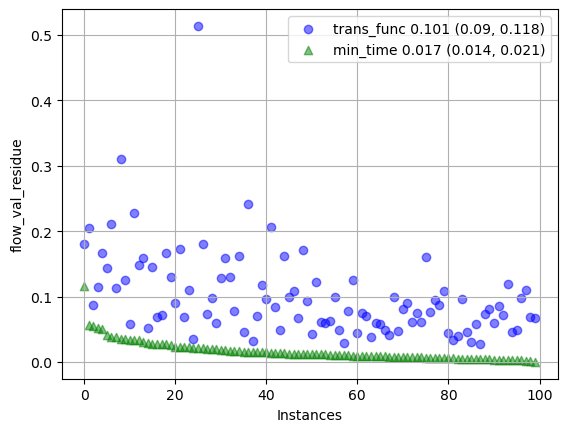

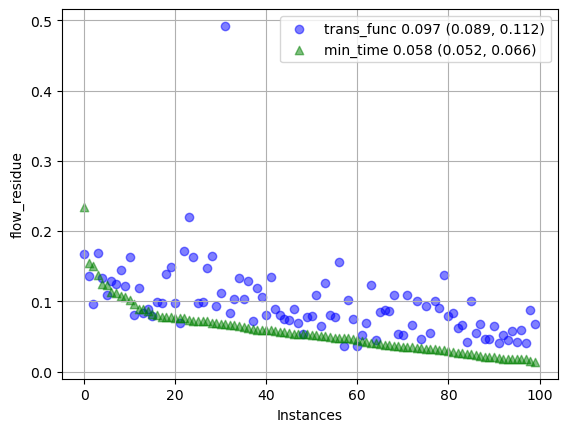

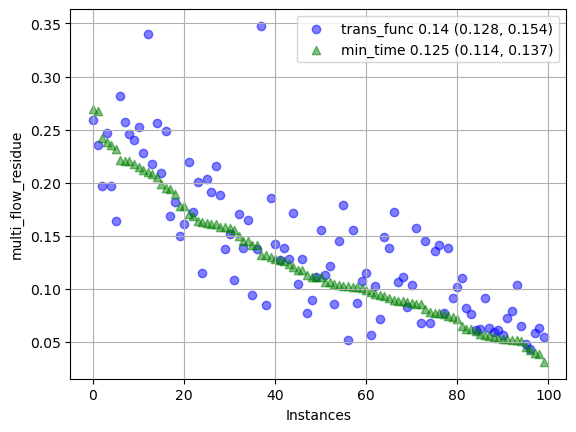

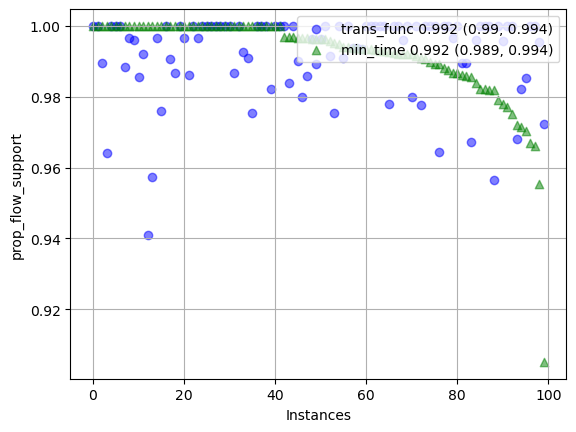

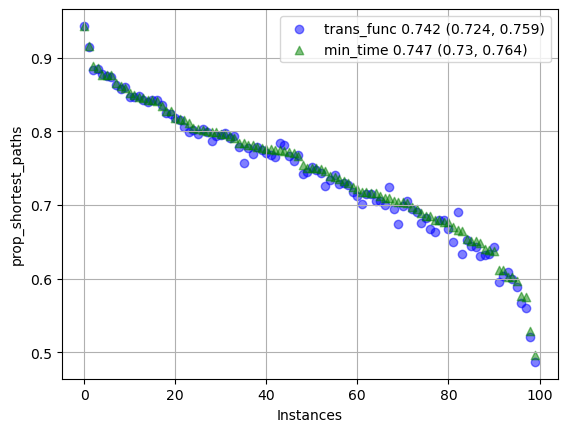

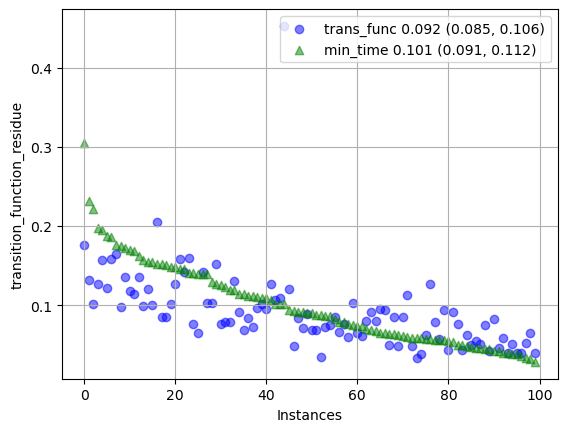

In [6]:
"""
Rank and compare in relation to a given baseline
"""
# Import pickle
import pickle

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

import pylab as py

import scipy.stats as stats

from IPython.display import clear_output

import sys

import os

os.chdir('C:\\Users\\HADDAM\\Documents\\Python Scripts\\multi_flow_decomp\\')

from utils.utils_stats import mean_confidence_interval


"""
{"res_key_metadata":res_key_metadata,
"res_value_metadata":res_value_metadata, 
"data":deepcopy(dict(dict_results))}
"""
simulated_instances = True
print("Simulated instances ", simulated_instances)

if simulated_instances:
    #path_baseline_heuristics = "results/simulated/MFDS_vs_RL/results_test/results_baseline_heuristics.pickle"
    path_baseline_heuristics = "results/temp/results_baseline_heuristics_temp.pickle"
else:
    #path_baseline_heuristics = "results/real/MFDS_vs_RL/results_versailles_baseline_heuristics.pickle"
    #path_baseline_heuristics = "results/results_lieusaint2_heuristics.pickle"
    path_baseline_heuristics = "results/real/MFDS_vs_RL/versailles/gpickle/random_pairs/results_baseline_heuristics_versailles.pickle"


with open(path_baseline_heuristics, 
          'rb') as handle:
    file = pickle.load(handle)
    test_names = file["res_key_metadata"]
    metric_names = file["res_value_metadata"]
    data_res_heur = file["data"]

"""
dict_results[(ind_instance, test)] = (flow_val_res, flow_res, m_flow_res, 
                                        prop_fsupp, prop_sp, trans_func_res)
test   -->    ["min_time", 
              "max_capacity", 
              "trans_func", 
              "random"]
"""
ref_test_name = "min_time"
comp_test_name = "trans_func"
# Unzip to display
nb_instances = len({id_inst for id_inst, _ in data_res_heur.keys()})
dict_perfs_heurs = {test_names[i]:[] for i in range(len(test_names))}
# Treatment of min_time
metrics_instances_ref = dict_perfs_heurs[ref_test_name]
for j in range(len(metric_names)):
    metrics_instances_ref.append([(id_inst, 
                                data_res_heur[(id_inst, ref_test_name)][j]) 
                                    for id_inst in range(nb_instances)])
    metrics_instances_ref[-1].sort(key = lambda x : -x[1])
# Treatment of trans_func
metrics_instances_comp = dict_perfs_heurs[comp_test_name]
for j in range(len(metric_names)):
    metrics_instances_comp.append([(metrics_instances_ref[j][i][0], 
                                    data_res_heur[(metrics_instances_ref[j][i][0], comp_test_name)][j]) 
                                        for i in range(nb_instances)])


close_ = False
colors = ['b', 'g', 'k', 'm', 'r', 'y']
markers = ["o", "^", "s", "x", "*", "h", "p"]
show_std = False
bins = 'auto'
#bins = 100
#force = None
force = "bootstrap"
with_pval_norm = False
save_path = "results/simulated/MFDS_vs_RL/results_compared_in_reference/"+ref_test_name+"__"+comp_test_name+"/"
for i in range(len(metric_names)):
    fig = plt.figure()
    j = 0
    for test_name in {ref_test_name, comp_test_name}:
        ### !!!!! size of vals !!!!! bedelha 
        vals = [e[1] for e in dict_perfs_heurs[test_name][i]]
        mean_ = np.mean(vals)
        std_ = np.std(vals, ddof=1)
        ci, pval_norm = mean_confidence_interval(vals, 
                                                confidence_normality_test = 0.95,
                                                force = force,
                                                confidence_level = 0.95)
        conf_int_str = "("+str(round(ci[0], 3))+", "+str(round(ci[1], 3))+")"
        added_pval_norm = " ^ "+str(round(pval_norm,3)) if with_pval_norm else ""
        if show_std:
            label = test_name+" "+str(round(mean_,3))+"+/-"+str(round(std_,3))+" "+conf_int_str+added_pval_norm
        else:
            label = test_name+" "+str(round(mean_,3))+" "+conf_int_str+added_pval_norm
        
        py.figure(fig.number)
        plt.scatter(list(range(len(vals))), 
                    vals, 
                    color = colors[j],
                    marker = markers[j], 
                    alpha = 0.5, 
                    label = label)
        j += 1

    py.figure(fig.number)
    plt.xlabel("Instances")
    plt.ylabel(metric_names[i])
    plt.legend(loc="upper right")
    plt.grid(visible = True)
    if save_path:
        fig.savefig(os.path.join(save_path, 
                                "comp_gen_base_heurs_"+metric_names[i]), 
                                bbox_inches='tight', 
                                pad_inches=0)
    if close_: plt.close(fig)
plt.show()

